In [1]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

C:\Users\hdadmin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#is_valid = True

path = 'D:\\PythonSamples\\Talking\\'

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    #df['dow']      = df['datetime'].dt.dayofweek
    #df["doy"]      = df["datetime"].dt.dayofyear
    df["hod"]      = df["datetime"].dt.hour
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df


In [3]:
start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }


In [4]:
train_ref = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

In [5]:
test_ref = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [6]:
# Drop the IP and the columns from target
train_ref.drop(['is_attributed'], axis=1, inplace=True)
gc.collect()
#nrow_train = train.shape[0]
merge_ref = pd.concat([train_ref, test_ref])
del train_ref, test_ref
gc.collect()

14

In [7]:
ip_count = merge_ref.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']

In [8]:
app_count = merge_ref.groupby(['app'])['channel'].count().reset_index()
app_count.columns = ['app', 'clicks_by_app']

In [9]:
del merge_ref
gc.collect()

35

In [10]:
#ip_count.head()

In [13]:
#app_count.head()

In [10]:
train_check = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

In [11]:
train_check["is_attributed"].sum()

456846

In [12]:
train_1 = train_check.loc[train_check["is_attributed"] == 1]

In [13]:
train_0 = train_check.loc[train_check["is_attributed"] == 0]

In [14]:
train_0f = train_0.sample(frac=0.05)

In [15]:
train = pd.concat([train_1, train_0f])
del  train_0f, train_1
gc.collect()

0

In [16]:
train.count()

ip               9679198
app              9679198
device           9679198
os               9679198
channel          9679198
click_time       9679198
is_attributed    9679198
dtype: int64

In [14]:
# Read the last lines because they are more impacting in training than the starting lines
#train = pd.read_csv(path+"train.csv", skiprows=range(1,127903891), nrows=57000000, usecols=train_columns, dtype=dtypes)
import random
p = 0.5
train_half = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes, skiprows=lambda i: i>0 and random.random() > p)

In [15]:
train = train_half.sample(frac=0.5)
del train_half

In [17]:
print(train.count())
gc.collect()

ip               46223738
app              46223738
device           46223738
os               46223738
channel          46223738
click_time       46223738
is_attributed    46223738
dtype: int64


9

In [17]:
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [16]:
# sum the number of attributed by app
#app_count = train.groupby(['app'])['is_attributed'].sum().reset_index()
#app_count.columns = ['app', 'app_attr_count']
#
#train = pd.merge(train, app_count, on='app', how='left', sort=False)
#train['app_attr_count'] = train['app_attr_count'].astype('uint16')

In [17]:
#os_count = train.groupby(['os'])['is_attributed'].sum().reset_index()
#os_count.columns = ['os', 'os_attr_count']

In [18]:
#train = pd.merge(train, os_count, on='os', how='left', sort=False)
#train['os_attr_count'] = train['os_attr_count'].astype('uint16')

In [19]:
#train.head()

In [20]:
#test.head()

In [21]:
#app_count.head()

In [22]:
#test = pd.merge(test, app_count, on='app', how='left', sort=False)
#test['app_attr_count'] = test['app_attr_count'].astype('uint16')
#test.head()

In [23]:
#test['app_attr_count'].fillna(0, inplace=True)

In [24]:
#test['app_attr_count'] = test['app_attr_count'].astype('uint16')

In [25]:
#test = pd.merge(test, os_count, on='os', how='left', sort=False)

In [26]:
#test['os_attr_count'].fillna(0, inplace=True)

In [27]:
#test['os_attr_count'] = train['os_attr_count'].astype('uint16')

In [18]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')
#test.drop(['click_id'], axis=1, inplace=True)
#gc.collect()

#nrow_train = train.shape[0]
#merge = pd.concat([train, test])
del test
gc.collect()

37

In [29]:
#merge.head()

In [19]:
# Count the number of clicks by ip
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')

In [20]:
#ip_app_count = merge.groupby(['ip','app'])['channel'].count().reset_index()
#ip_app_count.columns = ['ip', 'app', 'clicks_by_ip_app']

In [21]:
train = pd.merge(train, app_count, on=['app'], how='left', sort=False)
train['clicks_by_app'] = train['clicks_by_app'].astype('uint16')

In [22]:
train.drop('ip', axis=1, inplace=True)

In [23]:
#train = merge[:nrow_train]
#test = merge[nrow_train:]

#del test, merge
gc.collect()

35

In [24]:
print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

[2893.4998767375946] Start to generate time features
[2900.642101049423] Start XGBoost Training


In [25]:
train.head()

,app,device,os,channel,clicks_by_ip,clicks_by_app,hod
0,35,1,13,21,494,28753,15
1,9,1,22,215,3235,62860,16
2,35,1,13,21,17320,28753,16
3,35,1,46,274,1283,28753,16
4,35,1,13,274,1016,28753,16


In [35]:
print(xgb.__version__)

0.7


In [28]:
y.head()

12592010    0
37342174    0
31441852    0
49778355    0
25748249    0
Name: is_attributed, dtype: uint8

In [27]:
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [28]:
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
test = pd.merge(test, app_count, on=['app'], how='left', sort=False)

In [29]:
del ip_count
del app_count
gc.collect()

42

In [30]:
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test['clicks_by_app'] = test['clicks_by_app'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

In [31]:
test.head()

,app,device,os,channel,clicks_by_ip,clicks_by_app,hod
0,9,1,3,107,1134,62860,4
1,9,1,3,466,23273,62860,4
2,21,1,19,128,15544,60834,4
3,15,1,13,111,12827,64259,4
4,12,1,13,328,1441,8542,4


In [32]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

C:\Users\hdadmin\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [33]:
features = list(train.columns)  #la colonne 0 est le quote_conversionflag  
print(features)

['app', 'device', 'os', 'channel', 'clicks_by_ip', 'clicks_by_app', 'hod']


In [34]:
for f in train.columns:
    if train[f].dtype=='object':
        #print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [35]:
xgb_model = xgb.XGBClassifier()

In [36]:
# Set the params(this params from Pranav kernel) for xgboost model
parameters = {'learning_rate': [0.6,0.8],
          'booster': ["gbtree"],
          'max_depth': [4,5],
          'subsample': [0.6,0.8],
          'colsample_bytree': [0.3,0.5],
          'min_child_weight':[100,50],
          'reg_alpha':[2.0,4.0],
          'gamma':[0.6,0.8],
          'objective': ['binary:logistic'], 
          #'scale_pos_weight':[1,4,6,8,9],
          'nthread':[5],
          'random_state': [99], 
          'silent': [1]}


In [37]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(y, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [38]:
clf.fit(train[features], y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 77.4min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 397.4min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 921.9min
[Parallel(n_jobs=5)]: Done 640 out of 640 | elapsed: 1724.3min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'learning_rate': [0.6, 0.8], 'booster': ['gbtree'], 'max_depth': [4, 5], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.3, 0.5], 'min_child_weight': [1, 2], 'reg_alpha': [2.0, 4.0], 'gamma': [0.6, 0.8], 'objective': ['binary:logistic'], 'nthread': [5], 'random_state': [99], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [39]:
#staretd at 11:42am
print(time.time())    

1522326699.3335261


In [40]:
#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: 0.9739610338873373
booster: 'gbtree'
colsample_bytree: 0.5
gamma: 0.8
learning_rate: 0.6
max_depth: 5
min_child_weight: 2
nthread: 5
objective: 'binary:logistic'
random_state: 99
reg_alpha: 2.0
silent: 1
subsample: 0.8


In [41]:
test_probs = clf.predict_proba(test[features])[:,1]

In [42]:
sub['is_attributed'] = np.round(test_probs).astype(np.int64)

In [43]:
sub.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [44]:
sub.to_csv(path+'xgb_sub.csv',index=False)

# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          #'colsample_bylevel':0.7,
          'min_child_weight':1,
          'alpha':4,
          'gamma':9,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}


In [13]:
#del model

In [24]:
if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    #del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 50, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=1)
    #del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train_')]
    model = xgb.train(params, dtrain, 20, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))


[0]	train-auc:0.964144	valid-auc:0.964386
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[1]	train-auc:0.965099	valid-auc:0.965329
[2]	train-auc:0.965964	valid-auc:0.96601
[3]	train-auc:0.967191	valid-auc:0.967341
[4]	train-auc:0.967978	valid-auc:0.967972
[5]	train-auc:0.968341	valid-auc:0.968217
[6]	train-auc:0.970789	valid-auc:0.970124
[7]	train-auc:0.971983	valid-auc:0.971265
[8]	train-auc:0.972834	valid-auc:0.971619
[9]	train-auc:0.974162	valid-auc:0.97204
[10]	train-auc:0.975244	valid-auc:0.972074
[11]	train-auc:0.976367	valid-auc:0.971764
[12]	train-auc:0.977536	valid-auc:0.972044
[13]	train-auc:0.977962	valid-auc:0.972124
[14]	train-auc:0.978624	valid-auc:0.971632
[15]	train-auc:0.978869	valid-auc:0.971663
[16]	train-auc:0.97892	valid-auc:0.971756
[17]	train-auc:0.979431	valid-auc:0.971492
[18]	train-auc:0.979561	valid-auc:0.971528
[19]	train-auc:0.980488	valid-auc:0.971007
[20]	train

In [25]:
del x1, y1, x2, y2
del dvalid

In [26]:
# Plot the feature importance from xgboost
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [42]:
#!pip install graphviz

In [43]:
#%matplotlib inline
#from xgboost import plot_tree
#plot_tree(model, num_trees=0, rankdir='LR')

In [51]:
gc.collect()

1984

In [38]:
# Load the test for predict  18790469
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

In [44]:
#test.count()

In [35]:
#test = pd.merge(test, app_count, on='app', how='left', sort=False)
#test['app_attr_count'].fillna(0, inplace=True)
#test['app_attr_count'] = test['app_attr_count'].astype('uint16')
#test.head()

In [36]:
#test = pd.merge(test, os_count, on='os', how='left', sort=False)
#test['os_attr_count'].fillna(0, inplace=True)
#test['os_attr_count'] = test['os_attr_count'].astype('uint16')

In [39]:
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
#test = pd.merge(test, app_count, on=['app'], how='left', sort=False)

In [30]:
#test.head()

,click_id,ip,app,device,os,channel,click_time,clicks_by_ip,clicks_by_app
0,0,5744,9,1,3,107,2017-11-10 04:00:00,1134,19330444
1,1,119901,9,1,3,466,2017-11-10 04:00:00,23273,19330444
2,2,72287,21,1,19,128,2017-11-10 04:00:00,15544,4320674
3,3,78477,15,1,13,111,2017-11-10 04:00:00,12827,17038083
4,4,123080,12,1,13,328,2017-11-10 04:00:00,1441,26485086


In [40]:
del ip_count
#del app_count
gc.collect()

21

In [41]:
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
#test['clicks_by_app'] = test['clicks_by_app'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

In [42]:
test.head()

,app,device,os,channel,clicks_by_ip,hod
0,9,1,3,107,1134,4
1,9,1,3,466,23273,4
2,21,1,19,128,15544,4
3,15,1,13,111,12827,4
4,12,1,13,328,1441,4


In [34]:
dtest = xgb.DMatrix(test)
del test
gc.collect()

159

In [35]:
# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)


In [45]:
sub['is_attributed'] = test_probs

In [36]:
gc.collect()

7

In [47]:
def findresult(row):
    if row['is_attributed'] > 0.03:
        return 1
    else:
        return 0
    #return int(round(row['is_attributed']))

In [48]:
sub['is_attributed'] = sub.apply(findresult, axis = 1)

In [49]:
sub['is_attributed'] = sub['is_attributed'].astype(np.int64)

In [50]:
sub.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [51]:
sub.to_csv(path+'xgb_sub.csv',index=False)

In [48]:
df_vali = round(sub['is_attributed'],2)

In [49]:
df_v = pd.DataFrame({'id':df_vali.index, 'is_att':df_vali.values})

In [50]:
df_v.head()

,id,is_att
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


(array([  9.76959543e+00,   5.20859804e-02,   6.93990129e-02,
          2.94159768e-02,   2.54990974e-02,   1.18208864e-02,
          8.77200032e-03,   6.66454893e-03,   1.38000813e-02,
          1.29469892e-02]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

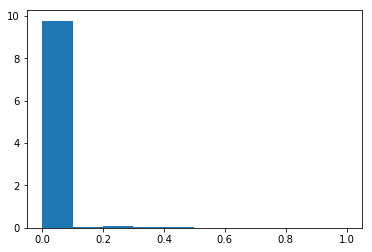

In [51]:
%matplotlib inline
plt.hist(df_v['is_att'], normed=True, bins=10)

In [55]:
df_v[df_v['is_att'] >= 0.1].count()

id        432941
is_att    432941
dtype: int64

In [ ]:
id        114402
is_att    114402

id        18672190
is_att    18672190

In [105]:
18672190+114402

18786592

In [15]:
184903891-456846

184447045

In [16]:
2000000/184447045

0.010843220611097347